In [1]:
from typing import Union, Optional
from dataclasses import dataclass
import math

import tensorflow as tf
import numpy as np
import PIL.Image as Image

2021-11-14 17:56:42.315384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 17:56:42.315407: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.__version__

'2.7.0'

In [3]:
lena = Image.open("imgs/Lenna512.png")
lists = Image.open("imgs/Lists512.png")
imgs = [np.array(i) / 255.0 for i in [lena, lists]]
imgs

[array([[[0.87843137, 0.51372549, 0.42352941],
         [0.8745098 , 0.50980392, 0.42352941],
         [0.87058824, 0.52156863, 0.43529412],
         ...,
         [0.81568627, 0.39607843, 0.36862745],
         [0.78823529, 0.36078431, 0.32941176],
         [0.72156863, 0.30980392, 0.31764706]],
 
        [[0.88235294, 0.51372549, 0.41960784],
         [0.8745098 , 0.51372549, 0.41960784],
         [0.8745098 , 0.5254902 , 0.43137255],
         ...,
         [0.78823529, 0.38039216, 0.36078431],
         [0.74117647, 0.31372549, 0.30980392],
         [0.62745098, 0.21568627, 0.26666667]],
 
        [[0.88235294, 0.51764706, 0.41960784],
         [0.8745098 , 0.51764706, 0.41568627],
         [0.8745098 , 0.52156863, 0.42352941],
         ...,
         [0.74509804, 0.3372549 , 0.34901961],
         [0.6627451 , 0.25882353, 0.30588235],
         [0.54117647, 0.14117647, 0.24313725]],
 
        ...,
 
        [[0.31764706, 0.08235294, 0.23137255],
         [0.32156863, 0.07843137, 0.22745

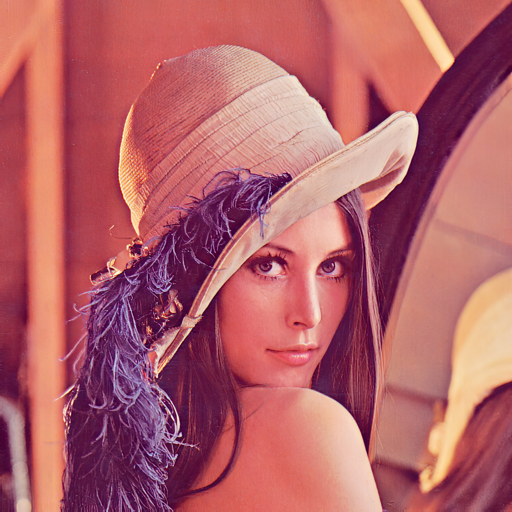

In [4]:
lena

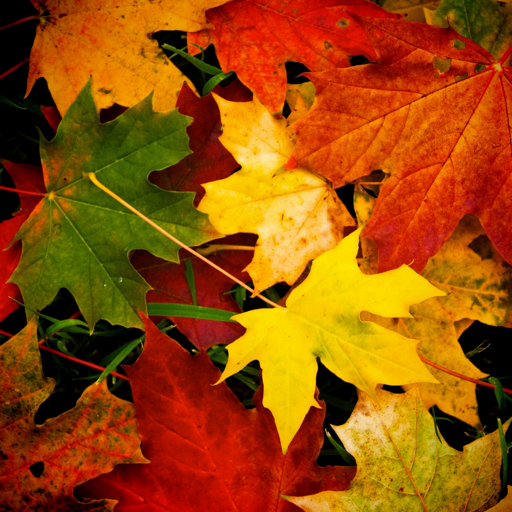

In [5]:
lists

In [6]:
def make_gauss_blur_kernel(size: int, scale: float = 3) -> np.ndarray:
    result = np.zeros(shape=[size], dtype=float)
    center = (size - 1) // 2
    div = ((center / scale) ** 2) * 2
    for i in range(size):
        x2 = (center - i)**2
        result[i] = math.exp( -x2 / div)
    return result / np.sum(result)

make_gauss_blur_kernel(11)

array([0.00266126, 0.01344761, 0.0474085 , 0.11660608, 0.20009684,
       0.23955941, 0.20009684, 0.11660608, 0.0474085 , 0.01344761,
       0.00266126])

In [7]:
@dataclass
class Report:
    image: np.ndarray
    gradient: np.ndarray
    image_source: np.ndarray
    loss_precise: float
    loss_gauss: float
    loss: float

class MyModel:
    def __init__(self, img_h: int, img_w: int, gauss_kernel_size: int, image_source: Optional[np.ndarray] = None):
        if image_source is None:
            image_source = np.zeros(shape=(1, img_h, img_w, 3), dtype=float)
        self.trainable_image = tf.Variable(initial_value=image_source, trainable=True)
        gauss_blur_kernel = make_gauss_blur_kernel(size=gauss_kernel_size, scale=3)
        self.gauss_kernel_x = tf.constant(gauss_blur_kernel[np.newaxis, :, np.newaxis, np.newaxis] * np.ones(shape=(1, 1, 3, 1)))
        self.gauss_kernel_y = tf.constant(gauss_blur_kernel[:, np.newaxis, np.newaxis, np.newaxis] * np.ones(shape=(1, 1, 3, 1)))

    def run(self, img_precise: np.ndarray, img_gauss: np.ndarray, m_precise = 1, m_gauss = 1) -> Report:
        with tf.GradientTape() as tape:
            trainable_image01 = tf.math.sigmoid(self.trainable_image)
            ## precise
            loss_precise = tf.reduce_sum(tf.square(trainable_image01 - img_precise[np.newaxis, :, :, :]))
            ## do gamma-correction, gaussian blur and inverted gamma-correction
            blurred = self.gauss_blur(trainable_image01 ** 2.2) ** (1.0 / 2.2)
            blurred_label = self.gauss_blur(img_gauss[np.newaxis, :, :, :] ** 2.2) ** (1.0 / 2.2)
            loss_gauss = tf.reduce_sum(tf.square(blurred - blurred_label))

            loss = loss_precise * m_precise + loss_gauss * m_gauss
        gradient = tape.gradient(loss, self.trainable_image)
        return Report(
            image=trainable_image01.numpy()[0],
            gradient=gradient.numpy(),
            image_source=self.trainable_image.numpy(),
            loss_precise=loss_precise.numpy(),
            loss_gauss=loss_gauss.numpy(),
            loss=loss.numpy(),
        )

    def apply_gradient(self, grad: np.ndarray, lr: float):
        self.trainable_image.assign(self.trainable_image.numpy() - lr * grad)

    def gauss_blur(self, inp: Union[tf.Tensor, np.ndarray]) -> tf.Tensor:
        r = inp
        r = tf.nn.depthwise_conv2d(r, self.gauss_kernel_x, strides=[1,1,1,1], padding='SAME')
        r = tf.nn.depthwise_conv2d(r, self.gauss_kernel_y, strides=[1,1,1,1], padding='SAME')
        return r

    def train(self, steps_count: int, print_loss_steps: int, lr: float, **run_kwargs) -> Report:
        for i in range(steps_count):
            r = self.run(**run_kwargs)
            model.apply_gradient(r.gradient, lr)
            if i % print_loss_steps == print_loss_steps - 1:
                print(f"{i}: loss = {r.loss}, precise = {r.loss_precise}, gauss = {r.loss_gauss}")
        return r

19: loss = 35488.08590064449, precise = 39559.15170783447, gauss = 31532.170729861038
39: loss = 19867.352917117914, precise = 50208.767654490504, gauss = 14846.476151668863
59: loss = 14997.51939659191, precise = 57588.96265853626, gauss = 9238.623130738284
79: loss = 12893.795079040414, precise = 62506.059139339864, gauss = 6643.189165106427
99: loss = 11792.354262194822, precise = 65935.50223298746, gauss = 5198.804038896075
119: loss = 11139.380606693037, precise = 68438.84701661102, gauss = 4295.495905031934
139: loss = 10717.631957402522, precise = 70336.99001085665, gauss = 3683.9329563168567
159: loss = 10427.78589294595, precise = 71821.60636043, gauss = 3245.6252569029507
179: loss = 10219.061282092862, precise = 73012.66915172592, gauss = 2917.7943669202687
199: loss = 10063.195515443167, precise = 73988.49217093903, gauss = 2664.3462983492627


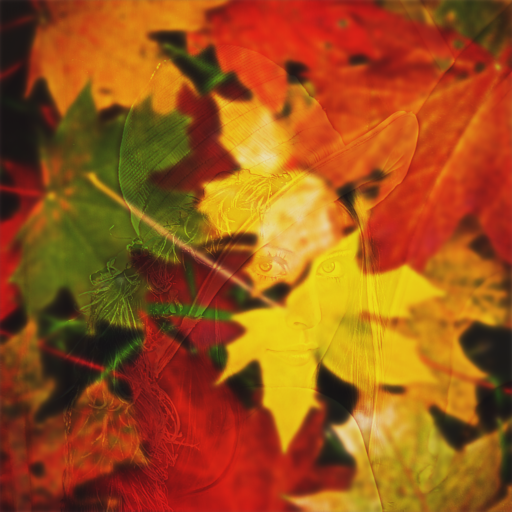

In [9]:
model = MyModel(512, 512, gauss_kernel_size=15)
r = model.train(steps_count=200, print_loss_steps=50, lr=0.3, img_precise=imgs[0], img_gauss=imgs[1], m_precise=0.1, m_gauss=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 9809.231509737616, precise = 75796.45826648093, gauss = 2229.5856830895236
99: loss = 9660.450646102434, precise = 77038.15661381673, gauss = 1956.6349847207612
149: loss = 9565.179198145337, precise = 77942.05726984111, gauss = 1770.9734711612257
199: loss = 9500.220128866738, precise = 78628.23799162185, gauss = 1637.3963297045536
249: loss = 9453.807719093256, precise = 79165.80935499918, gauss = 1537.2267835933376
299: loss = 9419.42101918496, precise = 79597.38505687274, gauss = 1459.6825134976862
349: loss = 9393.193538432459, precise = 79950.692774391, gauss = 1398.1242609933586
399: loss = 9372.707439579674, precise = 80244.56725972886, gauss = 1348.2507136067866
449: loss = 9356.384251288608, precise = 80492.2597317356, gauss = 1307.1582781150473
499: loss = 9343.156143857466, precise = 80703.36904719734, gauss = 1272.8192391377322


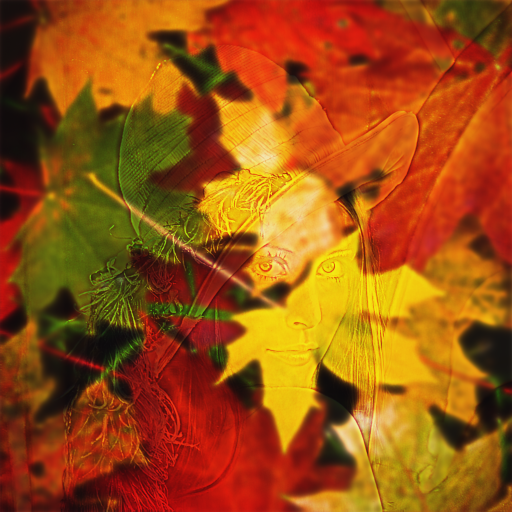

In [10]:
r = model.train(steps_count=500, print_loss_steps=50, lr=0.3, img_precise=imgs[0], img_gauss=imgs[1], m_precise=0.1, m_gauss=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 23978.393345886914, precise = 70084.64140667203, gauss = 2953.0009238853045
99: loss = 23562.898157401913, precise = 65725.19766878193, gauss = 3845.3388567673346
149: loss = 23356.467649407656, precise = 63264.64656229902, gauss = 4377.073680717951
199: loss = 23242.87549323535, precise = 61678.033608326274, gauss = 4739.46541073747
249: loss = 23177.548355277693, precise = 60607.949250957674, gauss = 4995.163579990392
299: loss = 23138.368259491184, precise = 59867.95825530327, gauss = 5177.980782900207
349: loss = 23113.940806613187, precise = 59345.763855634075, gauss = 5310.211649922965
399: loss = 23098.148809757175, precise = 58970.788591332224, gauss = 5406.912232357507
449: loss = 23087.559066466667, precise = 58697.45776620534, gauss = 5478.3217366050685
499: loss = 23080.182346868653, precise = 58495.574000795896, gauss = 5531.510146629885


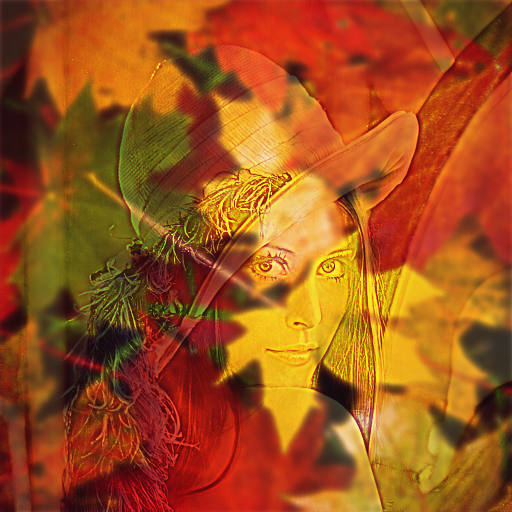

In [11]:
r = model.train(steps_count=500, print_loss_steps=50, lr=0.3, img_precise=imgs[0], img_gauss=imgs[1], m_precise=0.3, m_gauss=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 54966.70732071065, precise = 42776.11365271832, gauss = 12190.59366799233
99: loss = 51883.50327600875, precise = 34818.843840831294, gauss = 17064.659435177455
149: loss = 50619.288546892894, precise = 30662.687461626512, gauss = 19956.601085266382
199: loss = 49994.45017538396, precise = 28328.084538837793, gauss = 21666.365636546165
249: loss = 49649.1479839956, precise = 26928.165806883037, gauss = 22720.98217711256
299: loss = 49444.18285156916, precise = 26042.023746062798, gauss = 23402.159105506365
349: loss = 49316.26572814987, precise = 25455.98144513611, gauss = 23860.284283013763
399: loss = 49233.59789091346, precise = 25054.64234530238, gauss = 24178.955545611076
449: loss = 49178.86288630109, precise = 24772.105990232078, gauss = 24406.75689606901
499: loss = 49141.982160574276, precise = 24568.81371741369, gauss = 24573.168443160583
549: loss = 49116.78537185713, precise = 24419.96376414085, gauss = 24696.821607716276
599: loss = 49099.356816775864, precise =

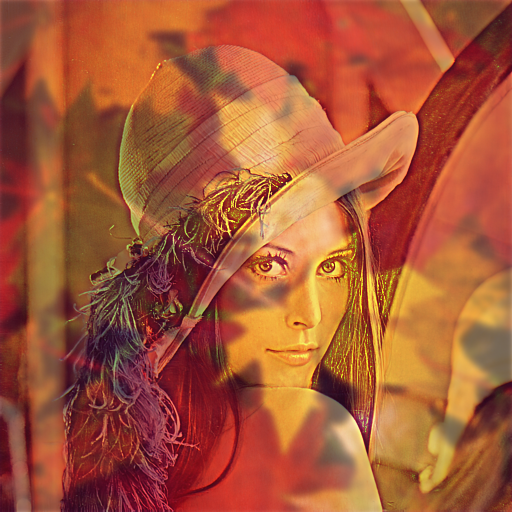

In [12]:
r = model.train(steps_count=1000, print_loss_steps=50, lr=0.1, img_precise=imgs[0], img_gauss=imgs[1], m_precise=1.0, m_gauss=1.0)
Image.fromarray(np.uint8(r.image * 255.0))